In [1]:
import sys
sys.path.insert(0, "../../../")

In [2]:
import deeplay as dl
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torchvision
import lightning as L

In [3]:
# Load the MNIST dataset and normalize it to [-1, 1]

mnist = torchvision.datasets.MNIST(
    root="../../data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

mnist_test = torchvision.datasets.MNIST(
    root="../../data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

In [4]:
mnist_dataloader = torch.utils.data.DataLoader(mnist, batch_size=32, num_workers=4)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=32, num_workers=4)

In [5]:
import matplotlib.pyplot as plt
import lightning as L
import os
from IPython.display import display, update_display

class PlottingCallback(L.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = {'train_loss': []}
        self.display_id = None
        
    def on_train_epoch_start(self, trainer, pl_module):
        self.plot_metrics(pl_module, trainer)
      
    def plot_metrics(self, gan, trainer):
        gan.eval()
        n = 5
        fig, ax = plt.subplots(n, 10, figsize=(10, n))
        for digit in range(10):
            x = gan.generate(torch.tensor([digit] * n).long().to(gan.device))
            for i in range(n):
                ax[i, digit].imshow(x[i].detach().cpu().numpy().transpose((1, 2, 0)), cmap="Greys", vmin=0, vmax=1)
                ax[i, digit].axis("off")
        
        fig.tight_layout()

        if self.display_id is None:
            display_handle = display(fig, display_id=True)
            self.display_id = display_handle.display_id
        else:
            update_display(fig, display_id=self.display_id)
        
        os.makedirs("figures", exist_ok=True)
        plt.savefig("figures/class_conditioned_epoch_{}.png".format(trainer.current_epoch))
        plt.close(fig)

        gan.train()


In [26]:
class Generator(dl.DeeplayModule):
    def __init__(self, decoder, output_layer):
        super().__init__()
        self.decoder = self.new("decoder")
        self.output_layer = self.new("output_layer")

    def forward(self, x):
        x = self.output_layer(self.decoder(x))
        x = x.view(-1, 1, 28, 28)
        return x
    

class Discriminator(dl.DeeplayModule):

    def __init__(self, preprocess_image, preprocess_condition, after_cat, output_layer):
        super().__init__()
        self.preprocess_image = self.new("preprocess_image")
        self.preprocess_condition = self.new("preprocess_condition")
        self.after_cat = self.new("after_cat")
        self.output_layer = self.new("output_layer")

    def forward(self, x, condition):
        x = self.preprocess_image(x)
        condition = self.preprocess_condition(condition)

        x = torch.cat([x, condition], dim=1)
        x = self.after_cat(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)

In [29]:

generator_config = (
    dl.Config()
    .decoder(dl.MultiLayerPerceptron, depth=3)
    .output_layer(nn.LazyLinear, out_features=28 * 28)
)

discriminator_config = (
    dl.Config()
    .preprocess_image(nn.Flatten)
    .preprocess_condition(nn.Identity)
    .after_cat(dl.MultiLayerPerceptron, depth=3)
    .output_layer(nn.LazyLinear, out_features=1)
)

generator = Generator.from_config(generator_config)
discriminator = Discriminator.from_config(discriminator_config)
print(generator)
print(discriminator)

Generator(
  (decoder): MultiLayerPerceptron(
    (depth): 3
    (blocks): ModuleList(
      (0): Template(
        (layer): LazyLinear(in_features=0, out_features=128, bias=True)
        (activation): ReLU()
      )
      (1): Template(
        (layer): LazyLinear(in_features=0, out_features=128, bias=True)
        (activation): ReLU()
      )
      (2): Template(
        (layer): LazyLinear(in_features=0, out_features=128, bias=True)
        (activation): ReLU()
      )
    )
  )
  (output_layer): LazyLinear(in_features=0, out_features=784, bias=True)
)
Discriminator(
  (preprocess_image): Flatten(start_dim=1, end_dim=-1)
  (preprocess_condition): Identity()
  (after_cat): MultiLayerPerceptron(
    (depth): 3
    (blocks): ModuleList(
      (0): Template(
        (layer): LazyLinear(in_features=0, out_features=128, bias=True)
        (activation): ReLU()
      )
      (1): Template(
        (layer): LazyLinear(in_features=0, out_features=128, bias=True)
        (activation): ReLU()
 

In [31]:
print(generator(torch.randn(1, 26))).shape
print(discriminator(torch.randn(1, 1, 28, 28), torch.randn(1, 5)).shape)

tensor([[[[ 4.2437e-03,  1.1985e-02,  1.0578e-02,  2.5256e-02, -8.1293e-02,
           -1.9708e-02,  3.8837e-02,  7.1358e-02, -1.9609e-03,  6.2019e-02,
           -4.2140e-02, -4.7617e-02, -5.3836e-02,  9.2445e-02, -5.4881e-02,
            6.2230e-02, -2.8234e-02,  4.6861e-02, -9.3345e-02, -1.3552e-01,
            7.9256e-02, -5.6370e-02, -7.2577e-02, -4.4121e-02,  8.6548e-02,
            4.8867e-02, -7.8031e-02, -4.0671e-02],
          [-5.8905e-02,  4.3745e-02, -1.4981e-02, -4.0523e-02, -5.3656e-03,
           -9.2549e-02,  8.0711e-02, -1.9849e-02,  4.3336e-02,  3.2620e-02,
           -7.7309e-02, -9.8936e-02, -1.0468e-02,  4.9215e-02, -4.8366e-02,
           -9.1877e-02, -6.5829e-02, -1.1302e-01,  1.4180e-01, -3.0839e-02,
           -9.7592e-02,  2.4719e-02, -4.1686e-02, -5.3575e-03, -1.6739e-02,
           -7.5082e-02, -9.4969e-02,  6.9881e-02],
          [-5.7168e-03, -9.0384e-02, -1.5324e-02,  2.8058e-02,  3.9391e-02,
           -2.6581e-02, -1.5707e-01,  3.1859e-02,  2.2311e-02,

AttributeError: 'NoneType' object has no attribute 'shape'

In [22]:

cgan_config = (
    dl.Config()
    .num_classes(10)
    .hidden_dim(20)
    .generator(Generator)
    .generator.merge(generator_config)
    .discriminator(Discriminator)
    .discriminator.merge(discriminator_config)
)

cgan = dl.ClassConditionedGAN.from_config(cgan_config)
cgan(torch.tensor([0] * 32).long())
print(cgan)

ClassConditionedGAN(
  (hidden_dim): 20
  (generator): Generator(
    (decoder): MultiLayerPerceptron(
      (depth): 3
      (blocks): ModuleList(
        (0): Template(
          (layer): Linear(in_features=25, out_features=128, bias=True)
          (activation): ReLU()
        )
        (1): Template(
          (layer): Linear(in_features=128, out_features=128, bias=True)
          (activation): ReLU()
        )
        (2): Template(
          (layer): Linear(in_features=128, out_features=128, bias=True)
          (activation): ReLU()
        )
      )
    )
    (output_layer): Linear(in_features=128, out_features=784, bias=True)
  )
  (discriminator): Discriminator(
    (preprocess_image): Flatten(start_dim=1, end_dim=-1)
    (preprocess_condition): Identity()
    (after_cat): MultiLayerPerceptron(
      (depth): 3
      (blocks): ModuleList(
        (0): Template(
          (layer): Linear(in_features=789, out_features=128, bias=True)
          (activation): ReLU()
        )
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type          | Params
-----------------------------------------------------
0 | generator          | Generator     | 137 K 
1 | discriminator      | Discriminator | 134 K 
2 | embedding          | Embedding     | 50    
3 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.087     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

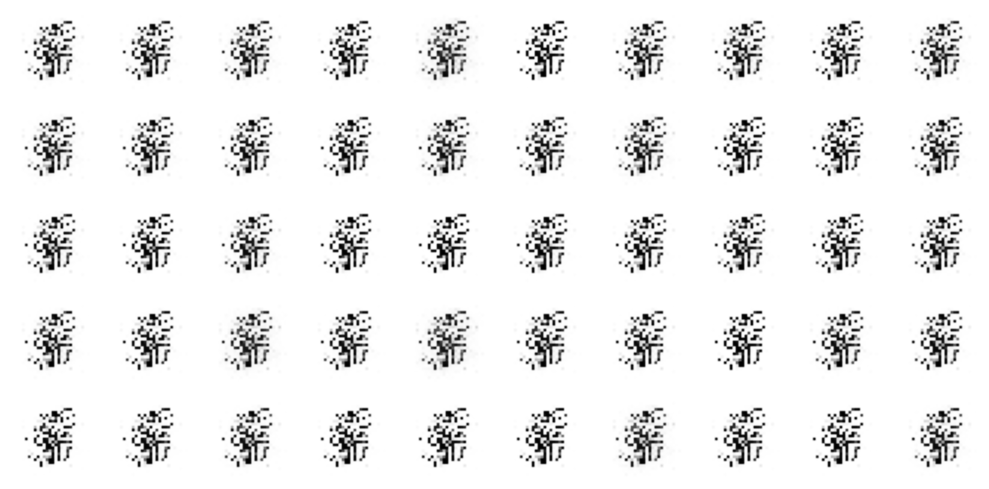

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [23]:

trainer = L.Trainer(max_epochs=20, accelerator="auto", callbacks=[PlottingCallback()])
trainer.fit(cgan, mnist_dataloader)

In [16]:
sample_images, sample_labels = next(iter(mnist_test_dataloader))

In [18]:
sample_images.max()

tensor(1.)

In [24]:

cgan_config = (
    dl.Config()
    .num_classes(10)
    .hidden_dim(10)
    .generator(Generator)
    .generator.merge(generator_config)
    .generator.decoder.depth(3)
    .generator.decoder.decoder_blocks[:3](dl.Layer("layer") >> dl.Layer("activation") >> dl.Layer("norm"))
    .generator.decoder.decoder_blocks[:3].norm(nn.LazyBatchNorm2d)
    .discriminator(Discriminator)
    .discriminator.merge(discriminator_config)
    .generator_optimizer(torch.optim.Adam, lr=5e-4)
)

cgan = dl.ClassConditionedGAN.from_config(cgan_config)
cgan(torch.tensor([0] * 32).long())
print(cgan)

ClassConditionedGAN(
  (hidden_dim): 10
  (generator): Generator(
    (decoder): SpatialBroadcastDecoder2d(
      (depth): 3
      (output_size): (28, 28)
      (input_block): Identity()
      (encoding): PositionalEncodingLinear2d()
      (decoder_blocks): ModuleList(
        (0): Template(
          (layer): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.1)
          (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Template(
          (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.1)
          (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): Template(
          (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.1)
          (norm): Bat

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type          | Params
-----------------------------------------------------
0 | generator          | Generator     | 314 K 
1 | discriminator      | Discriminator | 397 K 
2 | embedding          | Embedding     | 40    
3 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
712 K     Trainable params
0         Non-trainable params
712 K     Total params
2.849     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

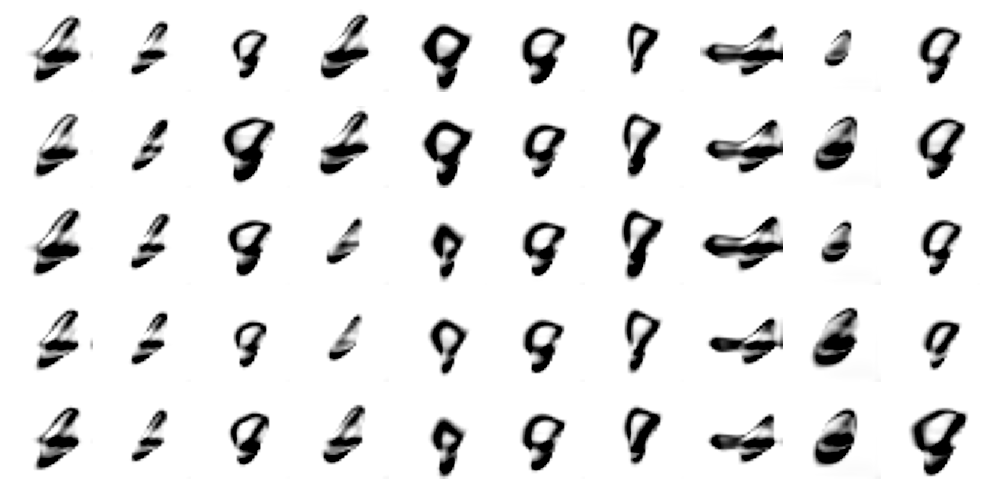

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [25]:

trainer = L.Trainer(max_epochs=20, accelerator="auto", callbacks=[PlottingCallback()])
trainer.fit(cgan, mnist_dataloader)

C:\Users\GU\AppData\Local\Temp\ipykernel_37044\899649882.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


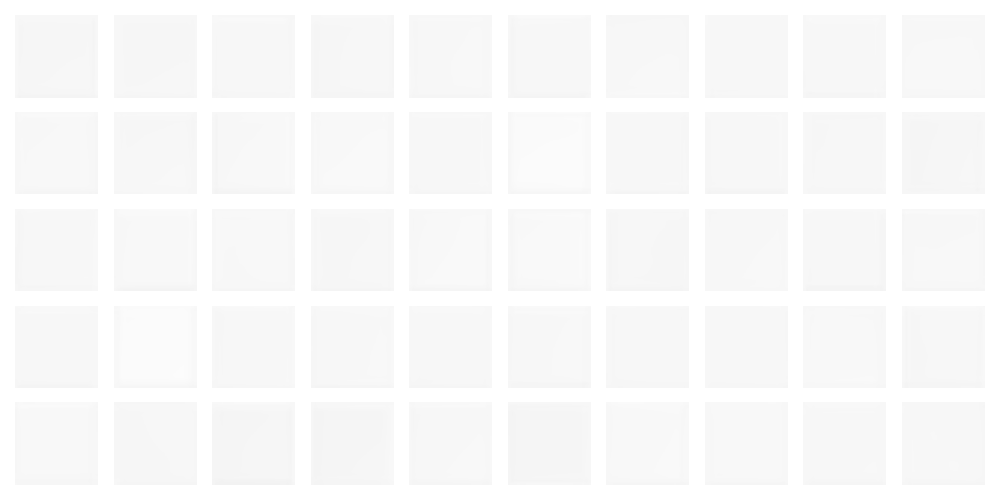

In [15]:
# Make a gif from the generated images
import IPython.display as ipd
import imageio
import glob
import os

images = []
filenames = sorted(glob.glob("figures/class_conditioned_epoch_*.png"))
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave("figures/class_conditioned.gif", images, duration=0.1)

# show the gif
ipd.Image("figures/class_conditioned.gif", width=800)
